In [4]:
import numpy as np
import pandas as pd

In [5]:
import tensorflow as tf

In [6]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [6]:
logging.info('abc')

08/15/2017 09:21:21 PM INFO: abc


In [7]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [8]:
LEN1=64*2
import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [9]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [14]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [15]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [16]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [17]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [18]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [19]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0909115851232


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 550)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[1024,1024]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_1024_nonzero', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/14/2017 09:00:36 PM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/14/2017 09:00:36 PM INFO: MyModel logits shape (?, 60)


(?, 1024) (?, 1036)
(?, 1024)
(?, 1024)
(?, 60)


08/14/2017 09:00:51 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/14/2017 09:00:51 PM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/14/2017 09:00:51 PM INFO: [epoch 0] start net training


(116050, 550) (29013, 550)
(116050, 550) (116050, 12)
(29013, 550) (29013, 12)


08/14/2017 09:01:40 PM INFO: [epoch 0][step 25600] AVG LOSS: 1.44557964802, smape: 1.43354213238
08/14/2017 09:02:29 PM INFO: [epoch 0][step 51200] AVG LOSS: 1.38543140888, smape: 1.35438501835
08/14/2017 09:03:17 PM INFO: [epoch 0][step 76800] AVG LOSS: 1.37707614899, smape: 1.3308545351
08/14/2017 09:04:06 PM INFO: [epoch 0][step 102400] AVG LOSS: 1.37813949585, smape: 1.31971633434
08/14/2017 09:04:54 PM INFO: [epoch 0][step 128000] AVG LOSS: 1.37072610855, smape: 1.30641281605
08/14/2017 09:05:42 PM INFO: [epoch 0][step 153600] AVG LOSS: 1.38310658932, smape: 1.31292057037
08/14/2017 09:06:31 PM INFO: [epoch 0][step 179200] AVG LOSS: 1.38008844852, smape: 1.30750072002
08/14/2017 09:07:20 PM INFO: [epoch 0][step 204800] AVG LOSS: 1.37043702602, smape: 1.29579055309
08/14/2017 09:08:08 PM INFO: [epoch 0][step 230400] AVG LOSS: 1.16392469406, smape: 1.14176249504
08/14/2017 09:08:57 PM INFO: [epoch 0][step 256000] AVG LOSS: 0.884102940559, smape: 0.883202135563
08/14/2017 09:09:00 PM

08/14/2017 10:01:24 PM INFO: [epoch 7][step 102400] AVG LOSS: 0.545322179794, smape: 0.542959392071
08/14/2017 10:02:13 PM INFO: [epoch 7][step 128000] AVG LOSS: 0.53957182169, smape: 0.537938296795
08/14/2017 10:03:01 PM INFO: [epoch 7][step 153600] AVG LOSS: 0.542334496975, smape: 0.540613949299
08/14/2017 10:03:50 PM INFO: [epoch 7][step 179200] AVG LOSS: 0.540380775928, smape: 0.539247572422
08/14/2017 10:04:39 PM INFO: [epoch 7][step 204800] AVG LOSS: 0.535475075245, smape: 0.53352367878
08/14/2017 10:05:28 PM INFO: [epoch 7][step 230400] AVG LOSS: 0.530248045921, smape: 0.528657197952
08/14/2017 10:06:16 PM INFO: [epoch 7][step 256000] AVG LOSS: 0.531150639057, smape: 0.529603362083
08/14/2017 10:06:19 PM INFO: [epoch 7] Valid LOSS: 0.525962531567, smape: 0.524221599102
08/14/2017 10:06:21 PM INFO: [epoch 8] start net training
08/14/2017 10:07:09 PM INFO: [epoch 8][step 25600] AVG LOSS: 0.528504729271, smape: 0.526591062546
08/14/2017 10:07:58 PM INFO: [epoch 8][step 51200] AVG L

08/14/2017 11:00:20 PM INFO: [epoch 14][step 153600] AVG LOSS: 0.463507354259, smape: 0.461740255356
08/14/2017 11:01:09 PM INFO: [epoch 14][step 179200] AVG LOSS: 0.46578848362, smape: 0.464250057936
08/14/2017 11:01:57 PM INFO: [epoch 14][step 204800] AVG LOSS: 0.463511496782, smape: 0.461452871561
08/14/2017 11:02:46 PM INFO: [epoch 14][step 230400] AVG LOSS: 0.4571659863, smape: 0.456046611071
08/14/2017 11:03:34 PM INFO: [epoch 14][step 256000] AVG LOSS: 0.465061485767, smape: 0.463499575853
08/14/2017 11:03:37 PM INFO: [epoch 14] Valid LOSS: 0.456912517548, smape: 0.454020619392
08/14/2017 11:03:39 PM INFO: [epoch 15] start net training
08/14/2017 11:04:28 PM INFO: [epoch 15][step 25600] AVG LOSS: 0.464651226997, smape: 0.462128788233
08/14/2017 11:05:16 PM INFO: [epoch 15][step 51200] AVG LOSS: 0.461500436068, smape: 0.459616541862
08/14/2017 11:06:05 PM INFO: [epoch 15][step 76800] AVG LOSS: 0.458495140076, smape: 0.457206040621
08/14/2017 11:06:53 PM INFO: [epoch 15][step 1024

08/14/2017 11:59:15 PM INFO: [epoch 21][step 204800] AVG LOSS: 0.437699884176, smape: 0.436092823744
08/15/2017 12:00:02 AM INFO: [epoch 21][step 230400] AVG LOSS: 0.442825049162, smape: 0.441120177507
08/15/2017 12:00:51 AM INFO: [epoch 21][step 256000] AVG LOSS: 0.436416387558, smape: 0.43487226963
08/15/2017 12:00:54 AM INFO: [epoch 21] Valid LOSS: 0.438528686762, smape: 0.436942338943
08/15/2017 12:00:56 AM INFO: [epoch 22] start net training
08/15/2017 12:01:44 AM INFO: [epoch 22][step 25600] AVG LOSS: 0.442126870155, smape: 0.438610434532
08/15/2017 12:02:33 AM INFO: [epoch 22][step 51200] AVG LOSS: 0.444393604994, smape: 0.442336320877
08/15/2017 12:03:21 AM INFO: [epoch 22][step 76800] AVG LOSS: 0.439296364784, smape: 0.437111854553
08/15/2017 12:04:10 AM INFO: [epoch 22][step 102400] AVG LOSS: 0.440051198006, smape: 0.438845664263
08/15/2017 12:04:59 AM INFO: [epoch 22][step 128000] AVG LOSS: 0.437766224146, smape: 0.435854613781
08/15/2017 12:05:48 AM INFO: [epoch 22][step 15

08/15/2017 12:58:09 AM INFO: [epoch 28][step 256000] AVG LOSS: 0.429445117712, smape: 0.427874386311
08/15/2017 12:58:12 AM INFO: [epoch 28] Valid LOSS: 0.434665411711, smape: 0.432860940695
08/15/2017 12:58:14 AM INFO: [epoch 29] start net training
08/15/2017 12:59:03 AM INFO: [epoch 29][step 25600] AVG LOSS: 0.431675314903, smape: 0.429740935564
08/15/2017 12:59:52 AM INFO: [epoch 29][step 51200] AVG LOSS: 0.432679980993, smape: 0.430910766125
08/15/2017 01:00:40 AM INFO: [epoch 29][step 76800] AVG LOSS: 0.427167207003, smape: 0.425701797009
08/15/2017 01:01:29 AM INFO: [epoch 29][step 102400] AVG LOSS: 0.430430829525, smape: 0.428369760513
08/15/2017 01:02:17 AM INFO: [epoch 29][step 128000] AVG LOSS: 0.427957952023, smape: 0.42620781064
08/15/2017 01:03:06 AM INFO: [epoch 29][step 153600] AVG LOSS: 0.431690871716, smape: 0.42990219593
08/15/2017 01:03:55 AM INFO: [epoch 29][step 179200] AVG LOSS: 0.429056048393, smape: 0.426997184753
08/15/2017 01:04:44 AM INFO: [epoch 29][step 204

08/15/2017 01:55:33 AM INFO: [epoch 36] start net training
08/15/2017 01:56:22 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.425054967403, smape: 0.422776222229
08/15/2017 01:57:10 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.428611397743, smape: 0.425745815039
08/15/2017 01:57:59 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.424092292786, smape: 0.421512901783
08/15/2017 01:58:48 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.424662172794, smape: 0.422271370888
08/15/2017 01:59:37 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.424801439047, smape: 0.423176407814
08/15/2017 02:00:25 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.425060540438, smape: 0.42297539115
08/15/2017 02:01:14 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.422498196363, smape: 0.421026676893
08/15/2017 02:02:03 AM INFO: [epoch 36][step 204800] AVG LOSS: 0.425376236439, smape: 0.423988103867
08/15/2017 02:02:51 AM INFO: [epoch 36][step 230400] AVG LOSS: 0.430211603642, smape: 0.427245408297
08/15/2017 02:03:39 AM INFO: [epoch 

08/15/2017 02:54:30 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.420675814152, smape: 0.418742954731
08/15/2017 02:55:18 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.423308193684, smape: 0.421121031046
08/15/2017 02:56:07 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.423076927662, smape: 0.421155929565
08/15/2017 02:56:56 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.42167454958, smape: 0.420039206743
08/15/2017 02:57:45 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.418036460876, smape: 0.416589349508
08/15/2017 02:58:34 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.424409687519, smape: 0.422791868448
08/15/2017 02:59:22 AM INFO: [epoch 43][step 204800] AVG LOSS: 0.41972219944, smape: 0.417258113623
08/15/2017 03:00:10 AM INFO: [epoch 43][step 230400] AVG LOSS: 0.421540081501, smape: 0.419984281063
08/15/2017 03:00:59 AM INFO: [epoch 43][step 256000] AVG LOSS: 0.420608669519, smape: 0.418751209974
08/15/2017 03:01:02 AM INFO: [epoch 43] Valid LOSS: 0.426804244518, smape: 0.422470867634
08/15

08/15/2017 03:42:01 AM INFO: [epoch 50][step 102400] AVG LOSS: 0.419641494751, smape: 0.417248487473
08/15/2017 03:42:29 AM INFO: [epoch 50][step 128000] AVG LOSS: 0.422064632177, smape: 0.419500648975
08/15/2017 03:42:57 AM INFO: [epoch 50][step 153600] AVG LOSS: 0.416466116905, smape: 0.414878576994
08/15/2017 03:43:25 AM INFO: [epoch 50][step 179200] AVG LOSS: 0.41885253787, smape: 0.41650557518
08/15/2017 03:43:53 AM INFO: [epoch 50][step 204800] AVG LOSS: 0.417659074068, smape: 0.416231513023
08/15/2017 03:44:22 AM INFO: [epoch 50][step 230400] AVG LOSS: 0.41688144207, smape: 0.414936602116
08/15/2017 03:44:50 AM INFO: [epoch 50][step 256000] AVG LOSS: 0.420723676682, smape: 0.418425858021
08/15/2017 03:44:51 AM INFO: [epoch 50] Valid LOSS: 0.41919696331, smape: 0.418026208878
08/15/2017 03:44:53 AM INFO: [epoch 51] start net training
08/15/2017 03:45:21 AM INFO: [epoch 51][step 25600] AVG LOSS: 0.418225824833, smape: 0.417047858238
08/15/2017 03:45:49 AM INFO: [epoch 51][step 512

08/15/2017 04:16:30 AM INFO: [epoch 57][step 153600] AVG LOSS: 0.419452399015, smape: 0.415759116411
08/15/2017 04:16:58 AM INFO: [epoch 57][step 179200] AVG LOSS: 0.416907608509, smape: 0.415153861046
08/15/2017 04:17:26 AM INFO: [epoch 57][step 204800] AVG LOSS: 0.416767537594, smape: 0.414639741182
08/15/2017 04:17:55 AM INFO: [epoch 57][step 230400] AVG LOSS: 0.41668471694, smape: 0.414093196392
08/15/2017 04:18:23 AM INFO: [epoch 57][step 256000] AVG LOSS: 0.414506793022, smape: 0.41290768981
08/15/2017 04:18:24 AM INFO: [epoch 57] Valid LOSS: 0.41917231679, smape: 0.41575050354
08/15/2017 04:18:26 AM INFO: [epoch 58] start net training
08/15/2017 04:18:54 AM INFO: [epoch 58][step 25600] AVG LOSS: 0.415750414133, smape: 0.414216816425
08/15/2017 04:19:22 AM INFO: [epoch 58][step 51200] AVG LOSS: 0.414855390787, smape: 0.413385152817
08/15/2017 04:19:50 AM INFO: [epoch 58][step 76800] AVG LOSS: 0.415892362595, smape: 0.414620965719
08/15/2017 04:20:18 AM INFO: [epoch 58][step 10240

08/15/2017 04:50:41 AM INFO: [epoch 64][step 204800] AVG LOSS: 0.412915050983, smape: 0.411188304424
08/15/2017 04:51:09 AM INFO: [epoch 64][step 230400] AVG LOSS: 0.413464456797, smape: 0.412136346102
08/15/2017 04:51:37 AM INFO: [epoch 64][step 256000] AVG LOSS: 0.415349930525, smape: 0.413456529379
08/15/2017 04:51:39 AM INFO: [epoch 64] Valid LOSS: 0.414515525103, smape: 0.413722991943
08/15/2017 04:51:40 AM INFO: [epoch 65] start net training
08/15/2017 04:52:08 AM INFO: [epoch 65][step 25600] AVG LOSS: 0.412760347128, smape: 0.410870194435
08/15/2017 04:52:37 AM INFO: [epoch 65][step 51200] AVG LOSS: 0.412464946508, smape: 0.41070151329
08/15/2017 04:53:05 AM INFO: [epoch 65][step 76800] AVG LOSS: 0.414701640606, smape: 0.411907315254
08/15/2017 04:53:33 AM INFO: [epoch 65][step 102400] AVG LOSS: 0.412557333708, smape: 0.41134005785
08/15/2017 04:54:01 AM INFO: [epoch 65][step 128000] AVG LOSS: 0.41296222806, smape: 0.41149738431
08/15/2017 04:54:30 AM INFO: [epoch 65][step 15360

08/15/2017 05:35:12 AM INFO: [epoch 71][step 256000] AVG LOSS: 0.412266910076, smape: 0.410372078419
08/15/2017 05:35:15 AM INFO: [epoch 71] Valid LOSS: 0.407260715961, smape: 0.406233906746
08/15/2017 05:35:17 AM INFO: [epoch 72] start net training
08/15/2017 05:36:06 AM INFO: [epoch 72][step 25600] AVG LOSS: 0.410447388887, smape: 0.409161686897
08/15/2017 05:36:55 AM INFO: [epoch 72][step 51200] AVG LOSS: 0.411422133446, smape: 0.409634947777
08/15/2017 05:37:44 AM INFO: [epoch 72][step 76800] AVG LOSS: 0.410421550274, smape: 0.40807980299
08/15/2017 05:38:32 AM INFO: [epoch 72][step 102400] AVG LOSS: 0.410887688398, smape: 0.408960342407
08/15/2017 05:39:21 AM INFO: [epoch 72][step 128000] AVG LOSS: 0.409810066223, smape: 0.408082723618
08/15/2017 05:40:10 AM INFO: [epoch 72][step 153600] AVG LOSS: 0.409838795662, smape: 0.408124268055
08/15/2017 05:40:59 AM INFO: [epoch 72][step 179200] AVG LOSS: 0.409712523222, smape: 0.408066749573
08/15/2017 05:41:48 AM INFO: [epoch 72][step 20

08/15/2017 06:32:46 AM INFO: [epoch 79] start net training
08/15/2017 06:33:35 AM INFO: [epoch 79][step 25600] AVG LOSS: 0.410418510437, smape: 0.408568620682
08/15/2017 06:34:23 AM INFO: [epoch 79][step 51200] AVG LOSS: 0.4089230299, smape: 0.407282561064
08/15/2017 06:35:12 AM INFO: [epoch 79][step 76800] AVG LOSS: 0.408301889896, smape: 0.406958609819
08/15/2017 06:36:01 AM INFO: [epoch 79][step 102400] AVG LOSS: 0.409289747477, smape: 0.407593280077
08/15/2017 06:36:51 AM INFO: [epoch 79][step 128000] AVG LOSS: 0.410591125488, smape: 0.408709764481
08/15/2017 06:37:39 AM INFO: [epoch 79][step 153600] AVG LOSS: 0.413451761007, smape: 0.409456253052
08/15/2017 06:38:28 AM INFO: [epoch 79][step 179200] AVG LOSS: 0.410327494144, smape: 0.40734398365
08/15/2017 06:39:17 AM INFO: [epoch 79][step 204800] AVG LOSS: 0.408808112144, smape: 0.40706372261
08/15/2017 06:40:06 AM INFO: [epoch 79][step 230400] AVG LOSS: 0.407691180706, smape: 0.40636280179
08/15/2017 06:40:55 AM INFO: [epoch 79][

08/15/2017 07:31:54 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.405403792858, smape: 0.403341650963
08/15/2017 07:32:43 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.405889868736, smape: 0.404260069132
08/15/2017 07:33:31 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.403829008341, smape: 0.402222037315
08/15/2017 07:34:20 AM INFO: [epoch 86][step 128000] AVG LOSS: 0.40567997098, smape: 0.404575645924
08/15/2017 07:35:09 AM INFO: [epoch 86][step 153600] AVG LOSS: 0.405179142952, smape: 0.403796434402
08/15/2017 07:35:58 AM INFO: [epoch 86][step 179200] AVG LOSS: 0.40302413702, smape: 0.401016622782
08/15/2017 07:36:46 AM INFO: [epoch 86][step 204800] AVG LOSS: 0.406348347664, smape: 0.405155032873
08/15/2017 07:37:35 AM INFO: [epoch 86][step 230400] AVG LOSS: 0.405727207661, smape: 0.402605205774
08/15/2017 07:38:24 AM INFO: [epoch 86][step 256000] AVG LOSS: 0.404316663742, smape: 0.403011858463
08/15/2017 07:38:27 AM INFO: [epoch 86] Valid LOSS: 0.401485919952, smape: 0.400326341391
08/15

08/15/2017 08:31:01 AM INFO: [epoch 93][step 102400] AVG LOSS: 0.402488797903, smape: 0.399936318398
08/15/2017 08:31:51 AM INFO: [epoch 93][step 128000] AVG LOSS: 0.403737425804, smape: 0.402086794376
08/15/2017 08:32:38 AM INFO: [epoch 93][step 153600] AVG LOSS: 0.400578379631, smape: 0.399010360241
08/15/2017 08:33:28 AM INFO: [epoch 93][step 179200] AVG LOSS: 0.407936483622, smape: 0.404620021582
08/15/2017 08:34:17 AM INFO: [epoch 93][step 204800] AVG LOSS: 0.404309570789, smape: 0.402897179127
08/15/2017 08:35:06 AM INFO: [epoch 93][step 230400] AVG LOSS: 0.40132817626, smape: 0.39973449707
08/15/2017 08:35:54 AM INFO: [epoch 93][step 256000] AVG LOSS: 0.405283749104, smape: 0.403598517179
08/15/2017 08:35:57 AM INFO: [epoch 93] Valid LOSS: 0.408575892448, smape: 0.408062636852
08/15/2017 08:35:58 AM INFO: [epoch 94] start net training
08/15/2017 08:36:47 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.402349561453, smape: 0.401041030884
08/15/2017 08:37:36 AM INFO: [epoch 94][step 5

08/15/2017 09:30:08 AM INFO: [epoch 100][step 153600] AVG LOSS: 0.401981443167, smape: 0.400119394064
08/15/2017 09:30:57 AM INFO: [epoch 100][step 179200] AVG LOSS: 0.402389883995, smape: 0.400640100241
08/15/2017 09:31:45 AM INFO: [epoch 100][step 204800] AVG LOSS: 0.40969479084, smape: 0.408237814903
08/15/2017 09:32:34 AM INFO: [epoch 100][step 230400] AVG LOSS: 0.400737255812, smape: 0.399310678244
08/15/2017 09:33:23 AM INFO: [epoch 100][step 256000] AVG LOSS: 0.403347730637, smape: 0.401292830706
08/15/2017 09:33:26 AM INFO: [epoch 100] Valid LOSS: 0.403046965599, smape: 0.40097334981
08/15/2017 09:33:28 AM INFO: [epoch 101] start net training
08/15/2017 09:34:17 AM INFO: [epoch 101][step 25600] AVG LOSS: 0.402484863997, smape: 0.400923758745
08/15/2017 09:35:05 AM INFO: [epoch 101][step 51200] AVG LOSS: 0.402744948864, smape: 0.400709807873
08/15/2017 09:35:54 AM INFO: [epoch 101][step 76800] AVG LOSS: 0.400608927011, smape: 0.399177670479
08/15/2017 09:36:43 AM INFO: [epoch 10

08/15/2017 10:28:26 AM INFO: [epoch 107][step 179200] AVG LOSS: 0.399205178022, smape: 0.397406339645
08/15/2017 10:29:15 AM INFO: [epoch 107][step 204800] AVG LOSS: 0.401252150536, smape: 0.399428516626
08/15/2017 10:30:04 AM INFO: [epoch 107][step 230400] AVG LOSS: 0.398748993874, smape: 0.397242456675
08/15/2017 10:30:53 AM INFO: [epoch 107][step 256000] AVG LOSS: 0.399309188128, smape: 0.397801846266
08/15/2017 10:30:56 AM INFO: [epoch 107] Valid LOSS: 0.40446549654, smape: 0.402966916561
08/15/2017 10:30:57 AM INFO: [epoch 108] start net training
08/15/2017 10:31:46 AM INFO: [epoch 108][step 25600] AVG LOSS: 0.399608582258, smape: 0.397593259811
08/15/2017 10:32:35 AM INFO: [epoch 108][step 51200] AVG LOSS: 0.400065004826, smape: 0.398887991905
08/15/2017 10:33:24 AM INFO: [epoch 108][step 76800] AVG LOSS: 0.400070101023, smape: 0.398761928082
08/15/2017 10:34:12 AM INFO: [epoch 108][step 102400] AVG LOSS: 0.397991627455, smape: 0.396567523479
08/15/2017 10:35:01 AM INFO: [epoch 1

08/15/2017 11:26:44 AM INFO: [epoch 114][step 204800] AVG LOSS: 0.394311875105, smape: 0.393023371696
08/15/2017 11:27:34 AM INFO: [epoch 114][step 230400] AVG LOSS: 0.395075291395, smape: 0.39395660162
08/15/2017 11:28:23 AM INFO: [epoch 114][step 256000] AVG LOSS: 0.394939988852, smape: 0.393689572811
08/15/2017 11:28:26 AM INFO: [epoch 114] Valid LOSS: 0.404474318027, smape: 0.403122425079
08/15/2017 11:28:27 AM INFO: [epoch 115] start net training
08/15/2017 11:29:16 AM INFO: [epoch 115][step 25600] AVG LOSS: 0.397566258907, smape: 0.39580360055
08/15/2017 11:30:04 AM INFO: [epoch 115][step 51200] AVG LOSS: 0.396166831255, smape: 0.394958138466
08/15/2017 11:30:53 AM INFO: [epoch 115][step 76800] AVG LOSS: 0.398457080126, smape: 0.397168010473
08/15/2017 11:31:42 AM INFO: [epoch 115][step 102400] AVG LOSS: 0.396427452564, smape: 0.395155608654
08/15/2017 11:32:31 AM INFO: [epoch 115][step 128000] AVG LOSS: 0.400985896587, smape: 0.396841645241
08/15/2017 11:33:19 AM INFO: [epoch 11

08/15/2017 12:25:02 PM INFO: [epoch 121][step 230400] AVG LOSS: 0.394731402397, smape: 0.393262982368
08/15/2017 12:25:50 PM INFO: [epoch 121][step 256000] AVG LOSS: 0.396823525429, smape: 0.395284384489
08/15/2017 12:25:53 PM INFO: [epoch 121] Valid LOSS: 0.397279113531, smape: 0.395783036947
08/15/2017 12:25:55 PM INFO: [epoch 122] start net training
08/15/2017 12:26:44 PM INFO: [epoch 122][step 25600] AVG LOSS: 0.397077292204, smape: 0.394029170275
08/15/2017 12:27:33 PM INFO: [epoch 122][step 51200] AVG LOSS: 0.397251844406, smape: 0.396009713411
08/15/2017 12:28:22 PM INFO: [epoch 122][step 76800] AVG LOSS: 0.398416638374, smape: 0.396991461515
08/15/2017 12:29:10 PM INFO: [epoch 122][step 102400] AVG LOSS: 0.397288918495, smape: 0.396133989096
08/15/2017 12:29:59 PM INFO: [epoch 122][step 128000] AVG LOSS: 0.396726697683, smape: 0.394577383995
08/15/2017 12:30:48 PM INFO: [epoch 122][step 153600] AVG LOSS: 0.393701851368, smape: 0.392650991678
08/15/2017 12:31:37 PM INFO: [epoch 

08/15/2017 01:23:19 PM INFO: [epoch 128][step 256000] AVG LOSS: 0.394560724497, smape: 0.39351439476
08/15/2017 01:23:22 PM INFO: [epoch 128] Valid LOSS: 0.395813673735, smape: 0.394097834826
08/15/2017 01:23:24 PM INFO: [epoch 129] start net training
08/15/2017 01:24:13 PM INFO: [epoch 129][step 25600] AVG LOSS: 0.393158614635, smape: 0.391706168652
08/15/2017 01:25:01 PM INFO: [epoch 129][step 51200] AVG LOSS: 0.397248536348, smape: 0.395702213049
08/15/2017 01:25:50 PM INFO: [epoch 129][step 76800] AVG LOSS: 0.392404556274, smape: 0.390973895788
08/15/2017 01:26:39 PM INFO: [epoch 129][step 102400] AVG LOSS: 0.398506700993, smape: 0.396453946829
08/15/2017 01:27:28 PM INFO: [epoch 129][step 128000] AVG LOSS: 0.394192814827, smape: 0.393060654402
08/15/2017 01:28:17 PM INFO: [epoch 129][step 153600] AVG LOSS: 0.391721904278, smape: 0.389325857162
08/15/2017 01:29:06 PM INFO: [epoch 129][step 179200] AVG LOSS: 0.393090963364, smape: 0.391994059086
08/15/2017 01:29:55 PM INFO: [epoch 1

08/15/2017 02:20:52 PM INFO: [epoch 135] Valid LOSS: 0.396190553904, smape: 0.395088344812
08/15/2017 02:20:53 PM INFO: [epoch 136] start net training
08/15/2017 02:21:42 PM INFO: [epoch 136][step 25600] AVG LOSS: 0.39596542716, smape: 0.393872916698
08/15/2017 02:22:31 PM INFO: [epoch 136][step 51200] AVG LOSS: 0.392541050911, smape: 0.391026943922
08/15/2017 02:23:19 PM INFO: [epoch 136][step 76800] AVG LOSS: 0.39349642396, smape: 0.392165005207
08/15/2017 02:24:08 PM INFO: [epoch 136][step 102400] AVG LOSS: 0.395419239998, smape: 0.394111454487
08/15/2017 02:24:57 PM INFO: [epoch 136][step 128000] AVG LOSS: 0.395024806261, smape: 0.392708063126
08/15/2017 02:25:46 PM INFO: [epoch 136][step 153600] AVG LOSS: 0.392958551645, smape: 0.391642391682
08/15/2017 02:26:35 PM INFO: [epoch 136][step 179200] AVG LOSS: 0.39463365078, smape: 0.393022835255
08/15/2017 02:27:23 PM INFO: [epoch 136][step 204800] AVG LOSS: 0.391252696514, smape: 0.390005022287
08/15/2017 02:28:12 PM INFO: [epoch 136

08/15/2017 03:18:22 PM INFO: [epoch 143] start net training
08/15/2017 03:19:09 PM INFO: [epoch 143][step 25600] AVG LOSS: 0.394448250532, smape: 0.393037825823
08/15/2017 03:19:59 PM INFO: [epoch 143][step 51200] AVG LOSS: 0.393229871988, smape: 0.39152058959
08/15/2017 03:20:48 PM INFO: [epoch 143][step 76800] AVG LOSS: 0.392516106367, smape: 0.391471505165
08/15/2017 03:21:37 PM INFO: [epoch 143][step 102400] AVG LOSS: 0.394218355417, smape: 0.392836809158
08/15/2017 03:22:25 PM INFO: [epoch 143][step 128000] AVG LOSS: 0.392443537712, smape: 0.390916317701
08/15/2017 03:23:14 PM INFO: [epoch 143][step 153600] AVG LOSS: 0.394000709057, smape: 0.392672002316
08/15/2017 03:24:03 PM INFO: [epoch 143][step 179200] AVG LOSS: 0.393969088793, smape: 0.3922778368
08/15/2017 03:24:52 PM INFO: [epoch 143][step 204800] AVG LOSS: 0.393361866474, smape: 0.391596019268
08/15/2017 03:25:41 PM INFO: [epoch 143][step 230400] AVG LOSS: 0.393312841654, smape: 0.392222374678
08/15/2017 03:26:29 PM INFO:

08/15/2017 04:16:39 PM INFO: [epoch 150][step 25600] AVG LOSS: 0.389070957899, smape: 0.387934595346
08/15/2017 04:17:28 PM INFO: [epoch 150][step 51200] AVG LOSS: 0.389943957329, smape: 0.388798564672
08/15/2017 04:18:16 PM INFO: [epoch 150][step 76800] AVG LOSS: 0.393056869507, smape: 0.390782088041
08/15/2017 04:19:05 PM INFO: [epoch 150][step 102400] AVG LOSS: 0.394311875105, smape: 0.392435997725
08/15/2017 04:19:54 PM INFO: [epoch 150][step 128000] AVG LOSS: 0.39374512434, smape: 0.392377972603
08/15/2017 04:20:43 PM INFO: [epoch 150][step 153600] AVG LOSS: 0.39460209012, smape: 0.393107265234
08/15/2017 04:21:31 PM INFO: [epoch 150][step 179200] AVG LOSS: 0.393305122852, smape: 0.391769498587
08/15/2017 04:22:20 PM INFO: [epoch 150][step 204800] AVG LOSS: 0.392569631338, smape: 0.391583889723
08/15/2017 04:23:09 PM INFO: [epoch 150][step 230400] AVG LOSS: 0.38955539465, smape: 0.388325452805
08/15/2017 04:23:58 PM INFO: [epoch 150][step 256000] AVG LOSS: 0.391558796167, smape: 0

08/15/2017 05:02:37 PM INFO: [epoch 157][step 51200] AVG LOSS: 0.390131115913, smape: 0.388767898083
08/15/2017 05:03:05 PM INFO: [epoch 157][step 76800] AVG LOSS: 0.393857508898, smape: 0.391534239054
08/15/2017 05:03:33 PM INFO: [epoch 157][step 102400] AVG LOSS: 0.390474170446, smape: 0.389046370983
08/15/2017 05:04:01 PM INFO: [epoch 157][step 128000] AVG LOSS: 0.389151275158, smape: 0.387855142355
08/15/2017 05:04:29 PM INFO: [epoch 157][step 153600] AVG LOSS: 0.38876453042, smape: 0.387537032366
08/15/2017 05:04:58 PM INFO: [epoch 157][step 179200] AVG LOSS: 0.392649292946, smape: 0.390829771757
08/15/2017 05:05:26 PM INFO: [epoch 157][step 204800] AVG LOSS: 0.391280591488, smape: 0.389787405729
08/15/2017 05:05:54 PM INFO: [epoch 157][step 230400] AVG LOSS: 0.388325721025, smape: 0.387129962444
08/15/2017 05:06:22 PM INFO: [epoch 157][step 256000] AVG LOSS: 0.394722014666, smape: 0.393067061901
08/15/2017 05:06:24 PM INFO: [epoch 157] Valid LOSS: 0.394623011351, smape: 0.3928518

08/15/2017 05:36:23 PM INFO: [epoch 164][step 76800] AVG LOSS: 0.392825961113, smape: 0.391417354345
08/15/2017 05:36:51 PM INFO: [epoch 164][step 102400] AVG LOSS: 0.388361692429, smape: 0.387198835611
08/15/2017 05:37:19 PM INFO: [epoch 164][step 128000] AVG LOSS: 0.388591170311, smape: 0.387683421373
08/15/2017 05:37:48 PM INFO: [epoch 164][step 153600] AVG LOSS: 0.390091866255, smape: 0.387991338968
08/15/2017 05:38:16 PM INFO: [epoch 164][step 179200] AVG LOSS: 0.390952825546, smape: 0.389914810658
08/15/2017 05:38:44 PM INFO: [epoch 164][step 204800] AVG LOSS: 0.394393920898, smape: 0.392853885889
08/15/2017 05:39:12 PM INFO: [epoch 164][step 230400] AVG LOSS: 0.390135109425, smape: 0.388812661171
08/15/2017 05:39:41 PM INFO: [epoch 164][step 256000] AVG LOSS: 0.389545977116, smape: 0.388012290001
08/15/2017 05:39:42 PM INFO: [epoch 164] Valid LOSS: 0.397505432367, smape: 0.396073818207
08/15/2017 05:39:44 PM INFO: [epoch 165] start net training
08/15/2017 05:40:12 PM INFO: [epoc

08/15/2017 06:10:11 PM INFO: [epoch 171][step 102400] AVG LOSS: 0.388741135597, smape: 0.387432903051
08/15/2017 06:10:39 PM INFO: [epoch 171][step 128000] AVG LOSS: 0.38850197196, smape: 0.386893182993
08/15/2017 06:11:08 PM INFO: [epoch 171][step 153600] AVG LOSS: 0.390879064798, smape: 0.389222025871
08/15/2017 06:11:36 PM INFO: [epoch 171][step 179200] AVG LOSS: 0.392710238695, smape: 0.391261547804
08/15/2017 06:12:04 PM INFO: [epoch 171][step 204800] AVG LOSS: 0.388485372066, smape: 0.387079000473
08/15/2017 06:12:32 PM INFO: [epoch 171][step 230400] AVG LOSS: 0.389002650976, smape: 0.386573493481
08/15/2017 06:13:01 PM INFO: [epoch 171][step 256000] AVG LOSS: 0.38879430294, smape: 0.387722194195
08/15/2017 06:13:02 PM INFO: [epoch 171] Valid LOSS: 0.400480270386, smape: 0.392990022898
08/15/2017 06:13:04 PM INFO: [epoch 172] start net training
08/15/2017 06:13:32 PM INFO: [epoch 172][step 25600] AVG LOSS: 0.388770371675, smape: 0.387805551291
08/15/2017 06:14:00 PM INFO: [epoch 

08/15/2017 06:44:00 PM INFO: [epoch 178][step 128000] AVG LOSS: 0.389661133289, smape: 0.388753205538
08/15/2017 06:44:28 PM INFO: [epoch 178][step 153600] AVG LOSS: 0.389154464006, smape: 0.387842357159
08/15/2017 06:44:56 PM INFO: [epoch 178][step 179200] AVG LOSS: 0.388041257858, smape: 0.386831134558
08/15/2017 06:45:24 PM INFO: [epoch 178][step 204800] AVG LOSS: 0.388734221458, smape: 0.387374639511
08/15/2017 06:45:53 PM INFO: [epoch 178][step 230400] AVG LOSS: 0.389772564173, smape: 0.388897657394
08/15/2017 06:46:21 PM INFO: [epoch 178][step 256000] AVG LOSS: 0.388483226299, smape: 0.387263983488
08/15/2017 06:46:23 PM INFO: [epoch 178] Valid LOSS: 0.396587014198, smape: 0.39530056715
08/15/2017 06:46:24 PM INFO: [epoch 179] start net training
08/15/2017 06:46:52 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.391230881214, smape: 0.389447122812
08/15/2017 06:47:21 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.388948172331, smape: 0.38771495223
08/15/2017 06:47:49 PM INFO: [epoch 1

08/15/2017 07:17:48 PM INFO: [epoch 185][step 153600] AVG LOSS: 0.390242427588, smape: 0.388800978661
08/15/2017 07:18:16 PM INFO: [epoch 185][step 179200] AVG LOSS: 0.389872044325, smape: 0.388408571482
08/15/2017 07:18:45 PM INFO: [epoch 185][step 204800] AVG LOSS: 0.388231664896, smape: 0.386828064919
08/15/2017 07:19:13 PM INFO: [epoch 185][step 230400] AVG LOSS: 0.389302670956, smape: 0.387645721436
08/15/2017 07:19:41 PM INFO: [epoch 185][step 256000] AVG LOSS: 0.386667132378, smape: 0.385423511267
08/15/2017 07:19:43 PM INFO: [epoch 185] Valid LOSS: 0.38564029336, smape: 0.383369624615
08/15/2017 07:19:45 PM INFO: [epoch 186] start net training
08/15/2017 07:20:13 PM INFO: [epoch 186][step 25600] AVG LOSS: 0.388909339905, smape: 0.387434154749
08/15/2017 07:20:41 PM INFO: [epoch 186][step 51200] AVG LOSS: 0.389894872904, smape: 0.388109654188
08/15/2017 07:21:09 PM INFO: [epoch 186][step 76800] AVG LOSS: 0.389571279287, smape: 0.388217926025
08/15/2017 07:21:38 PM INFO: [epoch 1

08/15/2017 07:51:38 PM INFO: [epoch 192][step 179200] AVG LOSS: 0.389860808849, smape: 0.388116449118
08/15/2017 07:52:06 PM INFO: [epoch 192][step 204800] AVG LOSS: 0.391293406487, smape: 0.38967782259
08/15/2017 07:52:34 PM INFO: [epoch 192][step 230400] AVG LOSS: 0.386444538832, smape: 0.385277211666
08/15/2017 07:53:03 PM INFO: [epoch 192][step 256000] AVG LOSS: 0.386689156294, smape: 0.385126382113
08/15/2017 07:53:04 PM INFO: [epoch 192] Valid LOSS: 0.393706202507, smape: 0.392333567142
08/15/2017 07:53:06 PM INFO: [epoch 193] start net training
08/15/2017 07:53:34 PM INFO: [epoch 193][step 25600] AVG LOSS: 0.387241899967, smape: 0.385807186365
08/15/2017 07:54:02 PM INFO: [epoch 193][step 51200] AVG LOSS: 0.390337914228, smape: 0.389121562243
08/15/2017 07:54:31 PM INFO: [epoch 193][step 76800] AVG LOSS: 0.388477146626, smape: 0.387446403503
08/15/2017 07:54:59 PM INFO: [epoch 193][step 102400] AVG LOSS: 0.388807058334, smape: 0.387732595205
08/15/2017 07:55:27 PM INFO: [epoch 1

08/15/2017 08:25:28 PM INFO: [epoch 199][step 204800] AVG LOSS: 0.387212872505, smape: 0.385987639427
08/15/2017 08:25:56 PM INFO: [epoch 199][step 230400] AVG LOSS: 0.388193845749, smape: 0.387011945248
08/15/2017 08:26:25 PM INFO: [epoch 199][step 256000] AVG LOSS: 0.388160020113, smape: 0.38688647747
08/15/2017 08:26:27 PM INFO: [epoch 199] Valid LOSS: 0.397664487362, smape: 0.396012336016
08/15/2017 08:26:28 PM INFO: BN request stop from train
08/15/2017 08:26:28 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [7]:
sess=tf.Session()

In [8]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_1024_nonzero/model_0-0.meta')

In [9]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_1024_nonzero/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_1024_nonzero/model_0-0


08/17/2017 05:37:18 AM INFO: Restoring parameters from tmp_pred60_lstm_1024_nonzero/model_0-0


In [10]:
graph = tf.get_default_graph()

In [11]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [36]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(20000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=part_y==5
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [37]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((20000, 128), (20000, 12), (20000, 60), (20000, 60))

In [38]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [39]:
sess.run(loss,feed_dict=feed_dict)

0.3958866

In [51]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 60)


In [52]:
a.max(),a.min()

(14207.705, 0.17104182)

In [53]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
20625.1


0.39748451

In [54]:
MASK.sum()

51889.0

In [55]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

614.118 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.614118


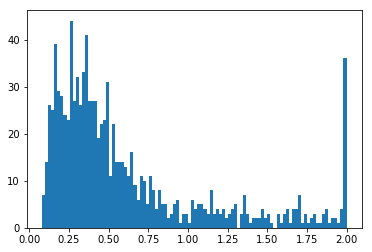

In [56]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

53.5 53.2769 0.432448


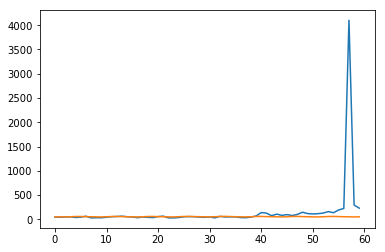

In [58]:
i=859
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [22]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [23]:
daily_test=daily_data[:,-128:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [24]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [25]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

0.0035401859881568696

In [27]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [28]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [29]:
submission=submission[["name",'Visits']]
submission.head()

name  Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...    17.9
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01    18.9
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01     4.5
3  4minute_zh.wikipedia.org_all-access_spider_201...    14.1
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...    10.9

In [30]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [31]:
keys_dict=keys["Id"].to_dict()

In [32]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [33]:
submission.isnull().sum().sum()

0L

In [34]:
submission.head()

name  Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...    17.9  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01    18.9  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01     4.5  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...    14.1  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...    10.9  75bae1fb2637

In [35]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_1024_nozero.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")